In [1]:
# Set directories
base_dir = '/home/vaibhavpawar/codes/kaggle/personalized_medicine/'
raw_data_dir = base_dir + 'raw_data/'
pro_data_dir = base_dir + 'processed_data/'

In [194]:
# imports
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import KeyedVectors
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, concatenate, Dropout, multiply
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU
from keras.models import Model
from keras import backend as K, initializers, activations, regularizers
from keras.engine.topology import Layer
import tensorflow as tf

In [43]:
MAX_SEQUENCE_LENGTH = 20000
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

In [3]:
train_variant = pd.read_csv(raw_data_dir + 'training_variants')
test_variant = pd.read_csv(raw_data_dir + 'test_variants')
train_text = pd.read_csv(raw_data_dir + 'training_text', sep='\|\|', engine='python', 
                         header=None, skiprows=1, names=['ID','Text'])
test_text = pd.read_csv(raw_data_dir + 'test_text', sep='\|\|', engine='python', 
                        header=None, skiprows=1, names=["ID","Text"])

In [4]:
train = pd.merge(train_variant, train_text, how='left', on='ID')
test = pd.merge(test_variant, test_text, how='left', on='ID')

In [5]:
texts = []

for row in train.itertuples():
    texts.append(row.Text)
    
for row in test.itertuples():
    texts.append(row.Text)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 197077 unique tokens.


In [9]:
pubmed_wv_file = '/home/vaibhavpawar/Downloads/pubmed_wv/wikipedia-pubmed-and-PMC-w2v.bin'
embeddings_index = KeyedVectors.load_word2vec_format(pubmed_wv_file, binary=True)

In [12]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
count_not_found = 0
count_found = 0
found = []
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
        found.append(i)
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
print count_not_found
print count_found
print len(found)

134919
62158
62158


In [ ]:
num_cores = multiprocessing.cpu_count()
print num_cores

def del_nf(s):
    for i in s:
        if i not in found:
            s.remove(i)
            
Parallel(n_jobs=num_cores)(delayed(del_nf)(s) for s in sequences)

16


In [25]:
seq_len = [len(s) for s in sequences]

In [39]:
sum([1 if sl <= 10000 else 0 for sl in seq_len])

5945

In [37]:
import pickle
with open(pro_data_dir + 'sequences.pkl', 'wb') as f:
    pickle.dump(sequences, f)

In [59]:
train_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [57]:
gene_embedding = np.zeros((8989, EMBEDDING_DIM))
count_not_found = 0
count_found = 0
for i, row in enumerate(train_variant.itertuples()):
    try:
        embedding_vector = embeddings_index[row.Gene]
        gene_embedding[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
for i, row in enumerate(test_variant.itertuples()):
    try:
        embedding_vector = embeddings_index[row.Gene]
        gene_embedding[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
print count_not_found
print count_found

56
8933


In [60]:
variation_embedding = np.zeros((8989, EMBEDDING_DIM))
count_not_found = 0
count_found = 0
for i, row in enumerate(train_variant.itertuples()):
    try:
        embedding_vector = embeddings_index[row.Variation]
        variation_embedding[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
for i, row in enumerate(test_variant.itertuples()):
    try:
        embedding_vector = embeddings_index[row.Variation]
        variation_embedding[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
print count_not_found
print count_found

5622
3367


In [177]:
class crossing(Layer):
    def __init__(self,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(crossing, self).__init__(**kwargs)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
        self.kernel = self.add_weight(shape=(input_dim, 1),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(1,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer)
        else:
            self.bias = None

    def call(self, inputs):
        
        #output = K.dot(K.dot(K.transpose(inputs), inputs), self.kernel)
        #shape1 = K.shape(inputs)
        #shape1[-1] = shape1[-1]**2
        #shape2 = K.shape(inputs)
        #inp_dim = shape2[-1]
        #shape2.append(inp_dim)
        #output = K.dot(K.reshape(multiply([K.repeat_elements(inputs, inp_dim, axis=1), 
        #                             K.reshape(K.repeat(inputs,inp_dim), tuple(shape1))]),
        #                   tuple(shape2)), self.kernel)
        
        shape = K.shape(inputs)
        shape1 = tf.stack([shape[0],shape[1],1])
        inputs_reshaped = K.reshape(inputs, shape1)        
        inputs_reshaped2 = K.permute_dimensions(inputs_reshaped, (0, 2, 1))
        
        output = K.reshape(K.dot(K.batch_dot(inputs_reshaped2, inputs_reshaped, axes=[1,2]), self.kernel), shape)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)

        if self.activation is not None:
            output = self.activation(output)
            
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        #output_shape[-1] = self.factors2
        return tuple(output_shape)

In [181]:
init1 = initializers.he_normal()

embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.3)(embedded_sequences)
x = Conv1D(128, 5, activation='relu', kernel_initializer=init1)(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 5, activation='relu', kernel_initializer=init1)(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 5, activation='relu', kernel_initializer=init1)(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)

ge_input = Input(shape=(200,))
ve_input = Input(shape=(200,))

x1 = concatenate([x, ge_input, ve_input], axis=-1)
x1 = Dropout(0.4)(x1)
x1_cross = crossing(activation='relu', kernel_initializer=init1)(x1)

x2 = concatenate([x1, x1_cross], axis=-1)

x2 = Dropout(0.3)(x2)

x2 = Dense(256, activation='relu', kernel_initializer=init1)(x2)
x2 = Dropout(0.3)(x2)
preds = Dense(9, activation='softmax', kernel_initializer=init1)(x2)

model = Model([sequence_input, ge_input, ve_input], preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [157]:
x_batch = K.variable([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.11, 0.21, 0.31], [0.41, 0.51, 0.61]])
#xy_batch_dot = K.batch_dot(K.repeat(x_batch,2), x_batch, axes=1)
#print K.int_shape(xy_batch_dot)
#K.get_value(K.repeat_elements(x_batch, 3, axis=1))
#K.get_value(K.reshape(K.repeat(x_batch,3),(4,9)))
#xy_batch_dot = K.reshape(multiply([K.repeat_elements(x_batch, 3, axis=1), K.reshape(K.repeat(x_batch,3),(4,9))]),(4,3,3))
#print K.int_shape(xy_batch_dot)
#K.get_value(xy_batch_dot)

(4, 3, 3)


array([[[ 0.01      ,  0.02      ,  0.03      ],
        [ 0.02      ,  0.04      ,  0.06      ],
        [ 0.03      ,  0.06      ,  0.09      ]],

       [[ 0.16000001,  0.2       ,  0.24000001],
        [ 0.2       ,  0.25      ,  0.30000001],
        [ 0.24000001,  0.30000001,  0.36000001]],

       [[ 0.0121    ,  0.0231    ,  0.0341    ],
        [ 0.0231    ,  0.0441    ,  0.0651    ],
        [ 0.0341    ,  0.0651    ,  0.0961    ]],

       [[ 0.1681    ,  0.20909999,  0.25010002],
        [ 0.20909999,  0.26009998,  0.31110001],
        [ 0.25010002,  0.31110001,  0.37210003]]], dtype=float32)

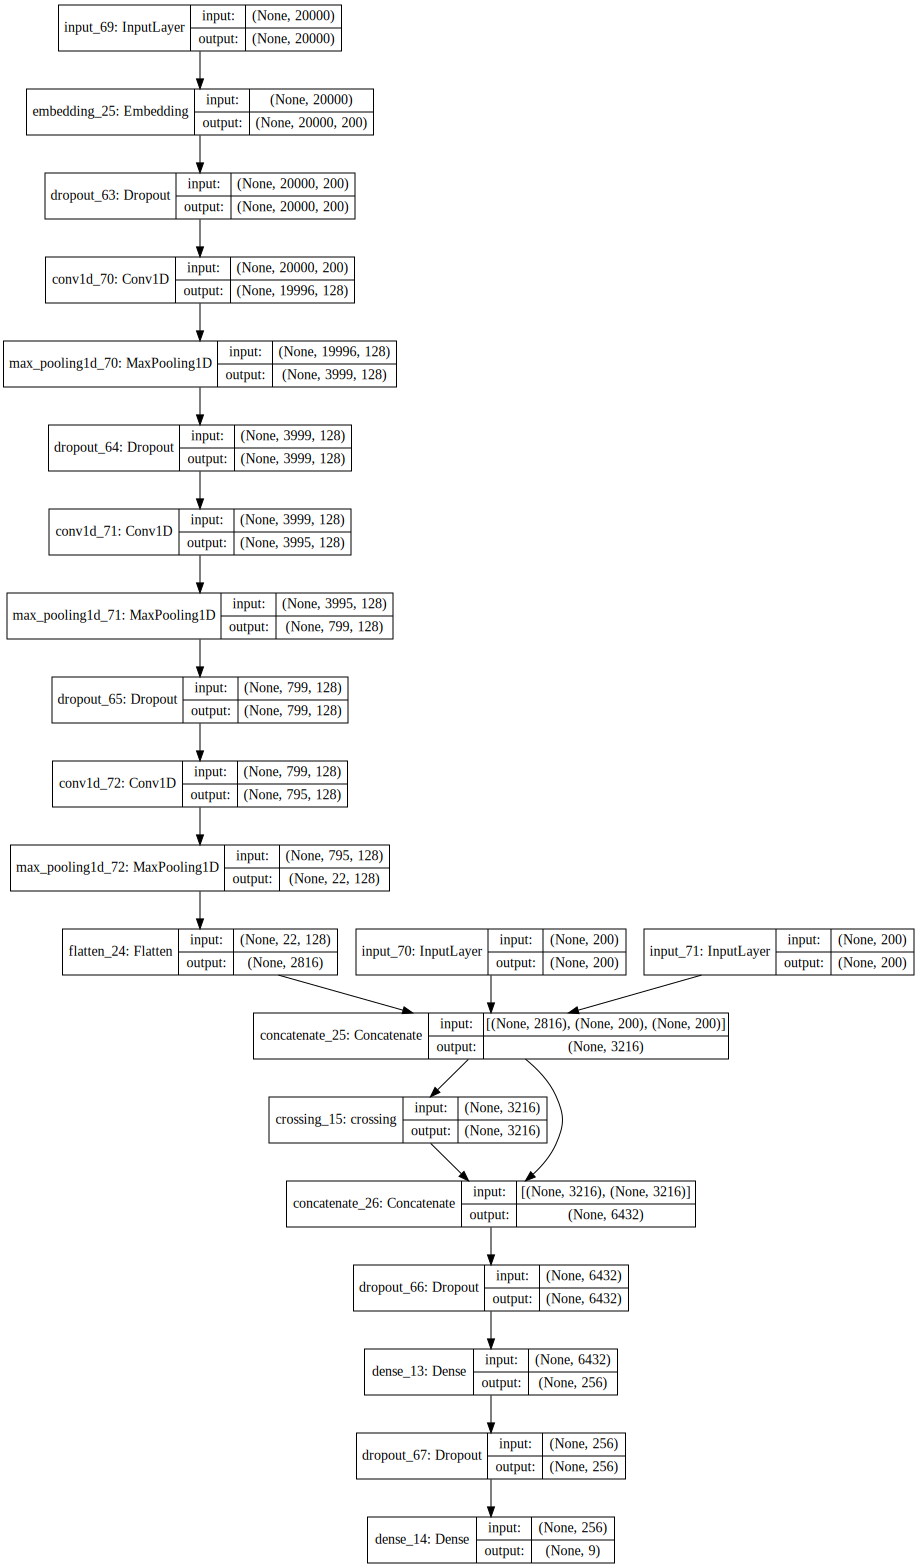

In [175]:
from keras.utils import plot_model
import pydot
pydot.find_graphviz = lambda: True

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [44]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

('Shape of data tensor:', (8989, 20000))


In [61]:
# split data into train and test
data_tr = data[0:3321,:]
data_ts = data[3321:,:]

gene_embedding_tr = gene_embedding[0:3321,:]
gene_embedding_ts = gene_embedding[3321:,:]

variation_embedding_tr = variation_embedding[0:3321,:]
variation_embedding_ts = variation_embedding[3321:,:]

# split the data into a training set and a validation set
indices = np.arange(data_tr.shape[0])
np.random.shuffle(indices)
data_tr = data_tr[indices]
labels = train[['Class']].values
labels = to_categorical(np.asarray(labels)-1)
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data_tr.shape[0])

In [62]:
x_tr = data_tr[:-num_validation_samples]
y_tr = labels[:-num_validation_samples]
x_vl = data_tr[-num_validation_samples:]
y_vl = labels[-num_validation_samples:]

ge_tr = gene_embedding_tr[:-num_validation_samples]
ge_vl = gene_embedding_tr[-num_validation_samples:]

ve_tr = variation_embedding_tr[:-num_validation_samples]
ve_vl = variation_embedding_tr[-num_validation_samples:]

print num_validation_samples
print x_tr.shape
print y_tr.shape
print x_vl.shape
print y_vl.shape
print ge_tr.shape
print ge_vl.shape
print ve_tr.shape
print ve_vl.shape

664
(2657, 20000)
(2657, 9)
(664, 20000)
(664, 9)
(2657, 200)
(664, 200)
(2657, 200)
(664, 200)


In [182]:
K.set_value(model.optimizer.lr, 0.001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 500s - loss: 1.9835 - acc: 0.2484 - val_loss: 1.9425 - val_acc: 0.2440


In [183]:
K.set_value(model.optimizer.lr, 0.001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 499s - loss: 1.8095 - acc: 0.2875 - val_loss: 1.8901 - val_acc: 0.2786


In [184]:
K.set_value(model.optimizer.lr, 0.001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 504s - loss: 1.7720 - acc: 0.3116 - val_loss: 1.8140 - val_acc: 0.3072
Epoch 2/10
2657/2657 [==============================] - 505s - loss: 1.6382 - acc: 0.3824 - val_loss: 1.7519 - val_acc: 0.3343
Epoch 3/10
2657/2657 [==============================] - 501s - loss: 1.5639 - acc: 0.4163 - val_loss: 1.6103 - val_acc: 0.3886
Epoch 4/10
2657/2657 [==============================] - 503s - loss: 1.4443 - acc: 0.4618 - val_loss: 1.4979 - val_acc: 0.4428
Epoch 5/10
2657/2657 [==============================] - 506s - loss: 1.4079 - acc: 0.4810 - val_loss: 1.4979 - val_acc: 0.4307
Epoch 6/10
2657/2657 [==============================] - 508s - loss: 1.3364 - acc: 0.5186 - val_loss: 1.4037 - val_acc: 0.4910
Epoch 7/10
2657/2657 [==============================] - 511s - loss: 1.2675 - acc: 0.5314 - val_loss: 1.4868 - val_acc: 0.4593
Epoch 8/10
2657/2657 [==============================] - 509s - l

In [185]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 606s - loss: 1.0194 - acc: 0.6221 - val_loss: 1.2884 - val_acc: 0.5256
Epoch 2/10
2657/2657 [==============================] - 506s - loss: 0.9971 - acc: 0.6251 - val_loss: 1.2726 - val_acc: 0.5301
Epoch 3/10
2657/2657 [==============================] - 549s - loss: 1.0012 - acc: 0.6346 - val_loss: 1.2814 - val_acc: 0.5286
Epoch 4/10
2657/2657 [==============================] - 623s - loss: 0.9786 - acc: 0.6353 - val_loss: 1.2701 - val_acc: 0.5346
Epoch 5/10
2657/2657 [==============================] - 624s - loss: 0.9735 - acc: 0.6443 - val_loss: 1.2702 - val_acc: 0.5286
Epoch 6/10
2657/2657 [==============================] - 624s - loss: 0.9656 - acc: 0.6425 - val_loss: 1.2712 - val_acc: 0.5256
Epoch 7/10
2657/2657 [==============================] - 550s - loss: 0.9610 - acc: 0.6470 - val_loss: 1.2700 - val_acc: 0.5241
Epoch 8/10
2657/2657 [==============================] - 509s - l

In [186]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 626s - loss: 0.9400 - acc: 0.6507 - val_loss: 1.2546 - val_acc: 0.5301
Epoch 2/10
2657/2657 [==============================] - 594s - loss: 0.9357 - acc: 0.6534 - val_loss: 1.2477 - val_acc: 0.5286
Epoch 3/10
2657/2657 [==============================] - 654s - loss: 0.9104 - acc: 0.6741 - val_loss: 1.2468 - val_acc: 0.5407
Epoch 4/10
2657/2657 [==============================] - 627s - loss: 0.9105 - acc: 0.6654 - val_loss: 1.2433 - val_acc: 0.5392
Epoch 5/10
2657/2657 [==============================] - 560s - loss: 0.9008 - acc: 0.6729 - val_loss: 1.2416 - val_acc: 0.5301
Epoch 6/10
2657/2657 [==============================] - 516s - loss: 0.8879 - acc: 0.6726 - val_loss: 1.2458 - val_acc: 0.5361
Epoch 7/10
2657/2657 [==============================] - 524s - loss: 0.8755 - acc: 0.6835 - val_loss: 1.2516 - val_acc: 0.5241
Epoch 8/10
2657/2657 [==============================] - 623s - l

In [187]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 585s - loss: 0.8595 - acc: 0.6955 - val_loss: 1.2380 - val_acc: 0.5392
Epoch 2/10
2657/2657 [==============================] - 530s - loss: 0.8644 - acc: 0.6737 - val_loss: 1.2318 - val_acc: 0.5497
Epoch 3/10
2657/2657 [==============================] - 513s - loss: 0.8590 - acc: 0.6835 - val_loss: 1.2451 - val_acc: 0.5392
Epoch 4/10
2657/2657 [==============================] - 505s - loss: 0.8384 - acc: 0.6955 - val_loss: 1.2324 - val_acc: 0.5361
Epoch 5/10
2657/2657 [==============================] - 515s - loss: 0.8468 - acc: 0.6967 - val_loss: 1.2286 - val_acc: 0.5467
Epoch 6/10
2657/2657 [==============================] - 530s - loss: 0.8361 - acc: 0.6925 - val_loss: 1.2257 - val_acc: 0.5512
Epoch 7/10
2657/2657 [==============================] - 595s - loss: 0.8156 - acc: 0.6982 - val_loss: 1.2269 - val_acc: 0.5557
Epoch 8/10
2657/2657 [==============================] - 598s - l

In [92]:
K.set_value(model.optimizer.lr, 0.001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=5,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 431s - loss: 1.1107 - acc: 0.5939 - val_loss: 1.3203 - val_acc: 0.5181
Epoch 2/5
2657/2657 [==============================] - 432s - loss: 1.0217 - acc: 0.6368 - val_loss: 1.2422 - val_acc: 0.5346
Epoch 3/5
2657/2657 [==============================] - 430s - loss: 1.0065 - acc: 0.6357 - val_loss: 1.2459 - val_acc: 0.5422
Epoch 4/5
2657/2657 [==============================] - 430s - loss: 0.9439 - acc: 0.6489 - val_loss: 1.2826 - val_acc: 0.5361
Epoch 5/5
2657/2657 [==============================] - 432s - loss: 0.9204 - acc: 0.6699 - val_loss: 1.2556 - val_acc: 0.5407


In [77]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 409s - loss: 0.6903 - acc: 0.7817 - val_loss: 1.1790 - val_acc: 0.5693


In [78]:
K.set_value(model.optimizer.lr, 0.00001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 412s - loss: 0.6576 - acc: 0.7941 - val_loss: 1.1790 - val_acc: 0.5678


In [79]:
K.set_value(model.optimizer.lr, 0.00001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 410s - loss: 0.6546 - acc: 0.7971 - val_loss: 1.1779 - val_acc: 0.5723


In [80]:
K.set_value(model.optimizer.lr, 0.000001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 409s - loss: 0.6511 - acc: 0.7953 - val_loss: 1.1779 - val_acc: 0.5693


In [81]:
K.set_value(model.optimizer.lr, 0.000001)
model.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 411s - loss: 0.6508 - acc: 0.7960 - val_loss: 1.1777 - val_acc: 0.5708


In [189]:
embedding_layer1 = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences1 = embedding_layer1(sequence_input1)
x1 = Dropout(0.3)(embedded_sequences1)
x1 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x1)
preds1 = Dense(9, activation='softmax')(x1)

model1 = Model(sequence_input1, preds1)
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

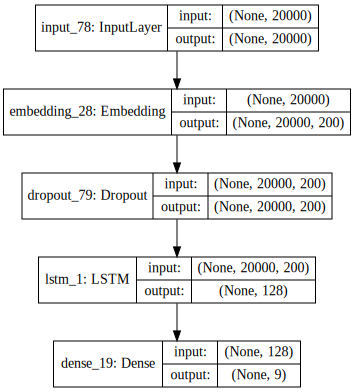

In [190]:
SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

In [192]:
K.set_value(model1.optimizer.lr, 0.001)
model1.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 2822s - loss: 1.8631 - categorical_accuracy: 0.3000 - val_loss: 1.7805 - val_categorical_accuracy: 0.3193
Epoch 2/5
2657/2657 [==============================] - 2858s - loss: 1.6853 - categorical_accuracy: 0.3703 - val_loss: 1.6996 - val_categorical_accuracy: 0.4051
Epoch 3/5
2657/2657 [==============================] - 2858s - loss: 1.6158 - categorical_accuracy: 0.3971 - val_loss: 1.6389 - val_categorical_accuracy: 0.4187
Epoch 4/5
2657/2657 [==============================] - 2874s - loss: 1.5479 - categorical_accuracy: 0.4313 - val_loss: 1.6053 - val_categorical_accuracy: 0.4292
Epoch 5/5
2657/2657 [==============================] - 2857s - loss: 1.5067 - categorical_accuracy: 0.4430 - val_loss: 1.5729 - val_categorical_accuracy: 0.4518


In [193]:
K.set_value(model1.optimizer.lr, 0.001)
model1.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 2859s - loss: 1.4709 - categorical_accuracy: 0.4509 - val_loss: 1.5709 - val_categorical_accuracy: 0.4127
Epoch 2/5
1152/2657 [============>.................] - ETA: 1480s - loss: 1.4807 - categorical_accuracy: 0.4332

KeyboardInterrupt: 

In [195]:
embedding_layer2 = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences2 = embedding_layer2(sequence_input2)
x2 = Dropout(0.3)(embedded_sequences2)
x2 = GRU(256, dropout=0.3, recurrent_dropout=0.3)(x2)
preds2 = Dense(9, activation='softmax')(x2)

model2 = Model(sequence_input2, preds2)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

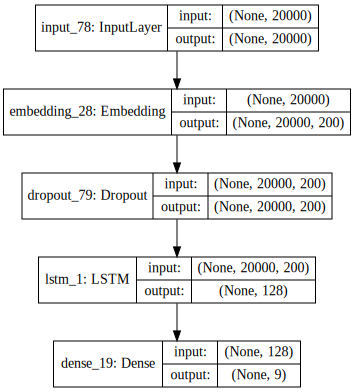

In [196]:
SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

In [197]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=2,
          validation_data=(x_vl, y_vl)) 

Train on 2657 samples, validate on 664 samples
Epoch 1/2
2657/2657 [==============================] - 5123s - loss: 1.8228 - acc: 0.3109 - val_loss: 1.7315 - val_acc: 0.3524
Epoch 2/2
2657/2657 [==============================] - 5511s - loss: 1.6309 - acc: 0.3869 - val_loss: 1.6399 - val_acc: 0.4202


In [198]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5403s - loss: 1.5690 - acc: 0.4170 - val_loss: 1.5792 - val_acc: 0.4292


In [199]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5181s - loss: 1.5143 - acc: 0.4403 - val_loss: 1.5412 - val_acc: 0.4639


In [200]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5502s - loss: 1.4856 - acc: 0.4505 - val_loss: 1.5186 - val_acc: 0.4623


In [201]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 6181s - loss: 1.4443 - acc: 0.4674 - val_loss: 1.4670 - val_acc: 0.4774


In [202]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5878s - loss: 1.4063 - acc: 0.4765 - val_loss: 1.4187 - val_acc: 0.4940


In [203]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5882s - loss: 1.3342 - acc: 0.5119 - val_loss: 1.3734 - val_acc: 0.5105


In [204]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 5658s - loss: 1.2923 - acc: 0.5303 - val_loss: 1.2919 - val_acc: 0.5527


In [205]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 8559s - loss: 1.2172 - acc: 0.5491 - val_loss: 1.2723 - val_acc: 0.5422


In [206]:
K.set_value(model2.optimizer.lr, 0.001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 7020s - loss: 1.1996 - acc: 0.5450 - val_loss: 1.2518 - val_acc: 0.5678


In [207]:
K.set_value(model2.optimizer.lr, 0.0001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 6904s - loss: 1.1385 - acc: 0.5807 - val_loss: 1.2287 - val_acc: 0.5617


In [208]:
K.set_value(model2.optimizer.lr, 0.0001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=1,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 6679s - loss: 1.1377 - acc: 0.5804 - val_loss: 1.2214 - val_acc: 0.5678


In [209]:
K.set_value(model2.optimizer.lr, 0.0001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 7053s - loss: 1.1279 - acc: 0.5837 - val_loss: 1.2141 - val_acc: 0.5663
Epoch 2/5
2657/2657 [==============================] - 5889s - loss: 1.1221 - acc: 0.5973 - val_loss: 1.2095 - val_acc: 0.5723
Epoch 3/5
2657/2657 [==============================] - 5178s - loss: 1.1215 - acc: 0.5898 - val_loss: 1.2036 - val_acc: 0.5753
Epoch 4/5
2657/2657 [==============================] - 5272s - loss: 1.0912 - acc: 0.5943 - val_loss: 1.1979 - val_acc: 0.5753
Epoch 5/5
2657/2657 [==============================] - 6295s - loss: 1.1197 - acc: 0.5883 - val_loss: 1.1983 - val_acc: 0.5768


In [210]:
K.set_value(model2.optimizer.lr, 0.0001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 6788s - loss: 1.0829 - acc: 0.6041 - val_loss: 1.1942 - val_acc: 0.5813
Epoch 2/5
2657/2657 [==============================] - 5360s - loss: 1.1042 - acc: 0.5954 - val_loss: 1.2046 - val_acc: 0.5527
Epoch 3/5
2657/2657 [==============================] - 5202s - loss: 1.1100 - acc: 0.5935 - val_loss: 1.1924 - val_acc: 0.5828
Epoch 4/5
2657/2657 [==============================] - 5199s - loss: 1.0777 - acc: 0.6067 - val_loss: 1.1926 - val_acc: 0.5768
Epoch 5/5
2657/2657 [==============================] - 5194s - loss: 1.0851 - acc: 0.6067 - val_loss: 1.1849 - val_acc: 0.5828


In [211]:
K.set_value(model2.optimizer.lr, 0.00001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 6274s - loss: 1.0624 - acc: 0.6112 - val_loss: 1.1844 - val_acc: 0.5828
Epoch 2/5
2657/2657 [==============================] - 6584s - loss: 1.0757 - acc: 0.5977 - val_loss: 1.1843 - val_acc: 0.5873
Epoch 3/5
2657/2657 [==============================] - 7605s - loss: 1.0897 - acc: 0.5920 - val_loss: 1.1833 - val_acc: 0.5828
Epoch 4/5
2657/2657 [==============================] - 7778s - loss: 1.0757 - acc: 0.6003 - val_loss: 1.1827 - val_acc: 0.5843
Epoch 5/5
2657/2657 [==============================] - 7610s - loss: 1.0782 - acc: 0.6037 - val_loss: 1.1821 - val_acc: 0.5828


In [212]:
K.set_value(model2.optimizer.lr, 0.00001)
model2.fit(x_tr, y_tr,
          batch_size=64,
          epochs=5,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/5
2657/2657 [==============================] - 6765s - loss: 1.1014 - acc: 0.5890 - val_loss: 1.1843 - val_acc: 0.5873
Epoch 2/5
2657/2657 [==============================] - 5667s - loss: 1.0850 - acc: 0.5962 - val_loss: 1.1844 - val_acc: 0.5873
Epoch 3/5
2657/2657 [==============================] - 5740s - loss: 1.0833 - acc: 0.6048 - val_loss: 1.1843 - val_acc: 0.5873
Epoch 4/5
2657/2657 [==============================] - 5277s - loss: 1.0788 - acc: 0.6014 - val_loss: 1.1846 - val_acc: 0.5873
Epoch 5/5
2657/2657 [==============================] - 5595s - loss: 1.0892 - acc: 0.6018 - val_loss: 1.1846 - val_acc: 0.5858


In [213]:
init1 = initializers.he_normal()

embedding_layer4 = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences4 = embedding_layer2(sequence_input4)
x4 = Dropout(0.3)(embedded_sequences4)
x4 = GRU(256, dropout=0.3, recurrent_dropout=0.3)(x4)

ge_input = Input(shape=(200,))
ve_input = Input(shape=(200,))

x5 = concatenate([x4, ge_input, ve_input], axis=-1)
x5 = Dropout(0.3)(x5)

preds4 = Dense(9, activation='softmax', kernel_initializer=init1)(x5)

model4 = Model([sequence_input4, ge_input, ve_input], preds4)
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print model4.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_80 (InputLayer)            (None, 20000)         0                                            
____________________________________________________________________________________________________
embedding_29 (Embedding)         (None, 20000, 200)    39415600    input_80[0][0]                   
____________________________________________________________________________________________________
dropout_81 (Dropout)             (None, 20000, 200)    0           embedding_29[1][0]               
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 256)           350976      dropout_81[0][0]                 
___________________________________________________________________________________________

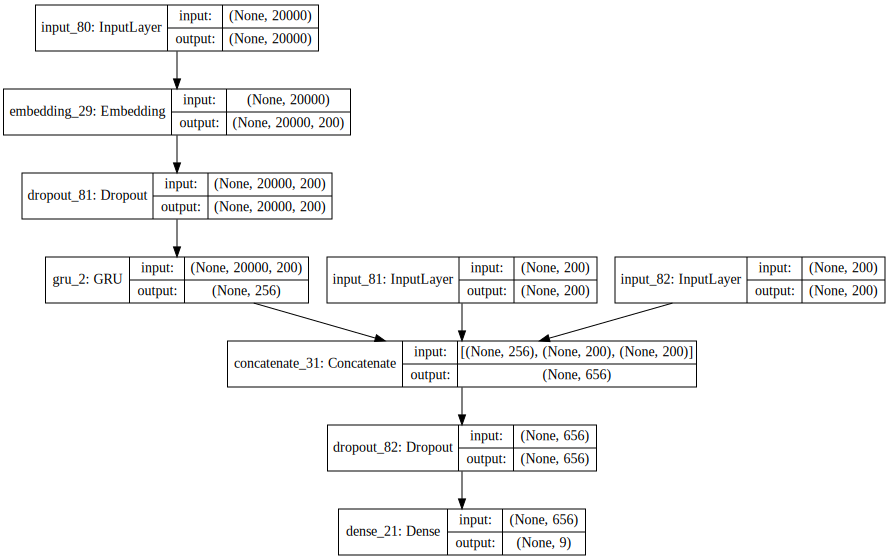

In [214]:
SVG(model_to_dot(model4, show_shapes=True).create(prog='dot', format='svg'))

In [216]:
K.set_value(model4.optimizer.lr, 0.001)
model4.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=1,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/1
2657/2657 [==============================] - 6825s - loss: 1.8745 - acc: 0.2826 - val_loss: 1.7873 - val_acc: 0.3283


In [217]:
K.set_value(model4.optimizer.lr, 0.001)
model4.fit([x_tr, ge_tr, ve_tr], y_tr,
          batch_size=64,
          epochs=4,
          validation_data=([x_vl, ge_vl, ve_vl], y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/4
2657/2657 [==============================] - 6540s - loss: 1.6986 - acc: 0.3700 - val_loss: 1.7351 - val_acc: 0.3494
Epoch 2/4
2657/2657 [==============================] - 6077s - loss: 1.6100 - acc: 0.4072 - val_loss: 1.6255 - val_acc: 0.4036
Epoch 3/4
2657/2657 [==============================] - 5978s - loss: 1.5467 - acc: 0.4370 - val_loss: 1.5962 - val_acc: 0.3946
Epoch 4/4
2657/2657 [==============================] - 6057s - loss: 1.5130 - acc: 0.4313 - val_loss: 1.5613 - val_acc: 0.4217
